In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [2]:
np.random.seed(42)
n_col = 4
n_row = int(1e4)
a = np.random.rand(n_row, n_col)
a.T[0] = -np.log(a.T[0])
a.T[1] *= 3
a.T[2]  = np.exp(a.T[2])
columns = ["col0", "col1", "col2", "col3"]
study_columns = ["col0", "col1", "col2", "col3"]
df = pd.DataFrame(a, columns=columns)
target = np.random.rand(n_row)
target = np.where(target > ((np.sum(a, axis=1))/np.max(np.sum(a, axis=1)))**0.2, 1, 0)
df["target"] = target
df.describe()

,col0,col1,col2,col3,target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.995982,1.489415,1.717266,0.501584,0.194800
std,0.997095,0.868873,0.489438,0.289826,0.396066
min,0.000129,0.000144,1.000006,0.000031,0.000000
25%,0.300976,0.730058,1.286230,0.250818,0.000000
50%,0.690557,1.486260,1.648936,0.502163,0.000000
75%,1.370019,2.242860,2.115211,0.752341,0.000000
max,9.112925,2.999368,2.718077,0.999901,1.000000


In [3]:
df.corr()

,col0,col1,col2,col3,target
col0,1.000000,-0.002701,-0.011046,0.004319,-0.080331
col1,-0.002701,1.000000,0.001342,-0.005841,-0.073491
col2,-0.011046,0.001342,1.000000,-0.002697,-0.033595
col3,0.004319,-0.005841,-0.002697,1.000000,-0.020617
target,-0.080331,-0.073491,-0.033595,-0.020617,1.000000


In [4]:
from sklearn.model_selection import train_test_split

In [5]:
train_df, test_df = train_test_split(df, test_size=0.25)

In [6]:
from ModelPoint import ModelPointDefiner, threshold_1d

In [7]:
mpd = ModelPointDefiner(train_df[study_columns+["target"]], "target")

In [8]:
n_estimation = 100
mpd.fit_cluster(n_estimation, init_mode="random", fit_mode="batch", batch_size=2500, alpha=0.005, compute_loss=True, truncate_cluster=20, max_iter=200, print_std=True)

  1%|          | 2/200 [00:00<00:23,  8.37it/s]16.419028215294166
16.28060722900569
  2%|▏         | 4/200 [00:00<00:23,  8.31it/s]16.0674651050826
16.425438010915126
  3%|▎         | 6/200 [00:00<00:26,  7.35it/s]16.236095692133
15.254171583292248
  4%|▍         | 8/200 [00:00<00:24,  8.00it/s]15.22395146014798
15.400111522422394
  5%|▌         | 10/200 [00:01<00:24,  7.83it/s]15.200597743021564
14.811278176404508
  6%|▌         | 12/200 [00:01<00:22,  8.47it/s]15.15551881964193
14.278443935486688
  7%|▋         | 14/200 [00:01<00:24,  7.55it/s]14.337300015873018
14.433340903612343
  8%|▊         | 16/200 [00:02<00:26,  7.00it/s]14.62982761196039
14.003017086850464
  9%|▉         | 18/200 [00:02<00:24,  7.55it/s]13.873688203817013
13.69614863874608
 10%|▉         | 19/200 [00:02<00:25,  7.11it/s]13.240896104112032
12.91898900875414
 10%|█         | 21/200 [00:02<00:25,  6.92it/s]13.437193596326294
12.913895541661386
 12%|█▏        | 23/200 [00:03<00:25,  7.04it/s]12.800298646100524
13

In [9]:
np.mean(np.max(mpd.lkm_.visited_cluster_through_iteration_list_, axis=0))

4.4585333333333335

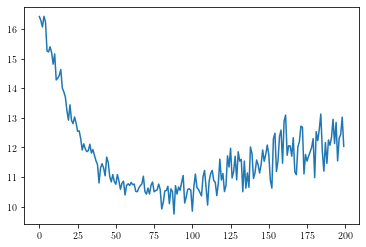

In [10]:
plt.plot(mpd.lkm_.loss_history_)
plt.show()

In [11]:
unique_labels, counts = np.unique(mpd.lkm_.labels_, return_counts=True)
np.std(counts)

12.034173409083367

In [12]:
px.scatter_matrix(test_df, dimensions=["col0", "col1", "col2", "col3"], color = mpd.predict_cluster(test_df[study_columns].values))

In [13]:
mpd.fit_EM()

Performing model selection with AIC
Current p is 1
Current p is 2
100%|██████████| 100/100 [00:00<00:00, 651.28it/s]


In [14]:
mpd.fit_BSG(columns=["col0"], normalization=[None])

In [15]:
mpd.set_hierarchy(6)

In [31]:
mpd.save("test_save")
del mpd
mpd = ModelPointDefiner()
mpd.load("test_save")
mpd

You did not provide a dataset, this behavior suppose that you will load a previously saved ModelPointDefiner before using it


In [32]:
mpd.model_from_data(train_df[study_columns].values)

array([1, 4, 1, ..., 1, 3, 2])

In [33]:
threshold_list = threshold_1d(mpd, "col0", int(1e5))
threshold_list

array([0.71711613, 1.16130887, 1.33024933, 3.1806265 , 5.27975009])

In [34]:
px.scatter(train_df, x="col0", y="col1", color=mpd.model_from_data(train_df[study_columns].values))

In [19]:
px.scatter_matrix(test_df, dimensions=["col0", "col1", "col2", "col3"], color = mpd.model_from_data(test_df[columns].values))

In [20]:
mpd.lkm_.n_clusters_

75

In [21]:
px.scatter_matrix(train_df.groupby(mpd.predict_cluster(train_df)).mean(), dimensions=["col0", "col1", "col2", "col3"], color = np.apply_along_axis(mpd.p_of_cluster, 0, np.arange(np.max(mpd.cluster_labels_)+1)))

In [22]:
from BinomialEM import plot_binomial_mixture

In [23]:
plot_binomial_mixture(mpd.bem_.p_, mpd.bem_.lambd_, mpd.data_.groupby(mpd.cluster_labels_)[mpd.target_].sum().values, n_estimation)

In [24]:
px.histogram(x=mpd.data_.groupby(mpd.cluster_labels_)[mpd.target_].sum().values)

In [25]:
px.scatter_matrix(train_df, dimensions=["col0", "col1", "col2", "col3"], color=mpd.cluster_labels_)

In [26]:
px.scatter_matrix(test_df, dimensions=["col0", "col1", "col2", "col3"], color=mpd.predict_cluster(test_df[columns]))

In [27]:
np.unique(mpd.cluster_labels_, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74]),
 array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100], dtype=int64))